# Quantum Counselor for Portfolio Investment

The Quantum Counselor for portfolio investment is a tool with two main objectives: forecasting the trend of assets price and optimizing portfolio returns both using quantum computing techniques. For the case of the forecasting method, we use a hybrid method that combines a deep learning model of classical LSTM layers with quantum layers. For the case of portfolio optimization, the quantum algorithms of QAOA and VQE are used to solve the problem and will be compared with CPLEX, a classical solver. Both tools are deeply connected because the forecasted price of the different assets is used for the cost function construction.

# Outline

1. Portfolio Optimization.


2. Stocks Selection.


3. Model XS (3 Stocks, 2 periods), QAOA and VQE with SPSA and COBYLA classical optimizers.


4. Model S  (5 Stocks, 3 periods), QAOA and VQE with SPSA and COBYLA classical optimizers.


5. Model M  (8 Stocks, 4 periods), QAOA and VQE with SPSA and COBYLA classical optimizers.


6. Novel Approach


7. References

## 1. Portfolio optimization

For portfolio optimization, we use the modern portfolio theory where we is wanted to maximize the return of an investment while keeping the risk of losing money low. We based or method in the work of Mugel et al. [<b>[1]<i>](https://doi.org/10.1103/PhysRevResearch.4.013006) where the cost function is described by:

<center><img src="images/Cost-function.png" width="800"></center>


Two main techniques:

- Portfolio optimization using QAOA, VQE, and Cplex (for classical comparison).
- Hybrid model to predict the stocks prices


Here, it is found:

- Apply the results of the Hybrid model of price prediction to optimize the portfolio.

three scenarios XS (3 stocks, 2 periods), S (5 stocks, 3 periods), M (8, 4)

The solution methods are QAOA, VQE (both in qasm_simulator and the power-up qiskit machine with 16 qubits for XS and S), CPLEX.
Using SPSA and COBYLA as classic solvers for comparison and changing the number of repetitions in QAOA and the Ansatz in VQE.
- Improving the model using the consideration, three possible actions for each stock, No invest, Medium investment, and High investment (I should use two-qubit for it and a restriction that qM(medium) + qH(high) < 1). Additionally, 
for the budget, restriction use the approach $t^2 - t$, additionally adding another risk parameter based on the uncertainity of the training stock variation prediction.

Same cases that for XS and S

In [1]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
import matplotlib.pyplot as plt
import numpy as np
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer 
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit import IBMQ
from qiskit_optimization.runtime import QAOAClient, QAOAProgram
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal
import pandas as pd
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE, QAOA

import warnings
warnings.filterwarnings('ignore')

### Functions developed by the authors

In [2]:
from portfolioFunctions import mu_fun, cov_matrix, portfolioOptimization, Optimization_QAOA, Optimization_VQE
from portfolioFunctions import profits, transaction_costs, portfolioOptimization_NewApproach

<div class="alert alert-block alert-info">
User -> Who is solving the notebook?
</div>

In [56]:
user = input()

Alejandro


In [57]:
provider = IBMQ.load_account()
users = ["Alejandro", "Alberto"]
if user == users[0]:
    provider_7 = IBMQ.get_provider(hub='ibm-q-research', group='guanajuato-1',project='main')
    backend_7 = provider_7.get_backend("ibmq_jakarta")
elif user == users[1]:
    provider_7 = IBMQ.get_provider(hub="ibm-q-community", group="qhack-hackathon", project="7-qubit")
    provider_16 = IBMQ.get_provider(hub="ibm-q-community", group="qhack-hackathon", project="16-qubit")
    backend_7 = provider_7.get_backend("ibm_perth")
    backend_16 = provider_16.get_backend("ibmq_guadalupe")

# 2. Stocks Selection

We select 8 stocks from 8 conglomerates based on the work from Xu et al. [<b>[2]<i>](https://aclanthology.org/P18-1183/): 

- Basic Materials: TOTAL S.A. "TOT"

- Consumer Goods: Appel Inc. "AAPL"

- Healthcare: AbbVie Inc. "ABBV"

- Services: Wall-Mart Stores Inc. "WMT"

- Utilites: Duke energy corporation "DUK"

- Financial: HSBS Holding pcl "HSBC"

- Industrial Goods: ABB Ltd. "ABB"

- Technology: China Mobile Limited "CHL"

The information comes from Sep 2012 to Sep 2017 with daily Technical information of Open, High, Low, Close, Adj Close, and Volume for the stocks price. From here, we use a **QNN** to predict the trend in the price of the stock. The results of the forecasting are stored in **stocks_forecasting**

In [3]:
stocks_name = ["AAPL","ABB", "ABBV","CHL", "DUK", "HSBC", "TOT", "WMT"]
stocks_forecasting = {}
stocks_real = {}
kappa = {}
period_of_test = 90 # Days known the real price but not used during training
for name in stocks_name:
    fore = np.load(f"./Data/Stocks_prediction/data_{name}_test.npy", allow_pickle=True)
    stocks_forecasting[name] = fore[:,0,1]
    stocks_real[name] = np.array(pd.read_csv(f"./Data/Stocks/{name}.csv")["Close"])
    kappa[name] = (np.abs(fore[:period_of_test,0,1] - fore[:period_of_test,0,0]) / fore[:period_of_test,0,0]).mean()

In [4]:
kappa

{'AAPL': 0.027383129127505013,
 'ABB': 0.017273633825249872,
 'ABBV': 0.014986074808461406,
 'CHL': 0.012665745549247202,
 'DUK': 0.01924290487227243,
 'HSBC': 0.04367506609431775,
 'TOT': 0.019441184398842275,
 'WMT': 0.018741103471092473}

In [5]:
pd.read_csv(f"./Data/Stocks/AAPL.csv")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000
1254,2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900
1255,2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600
1256,2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100


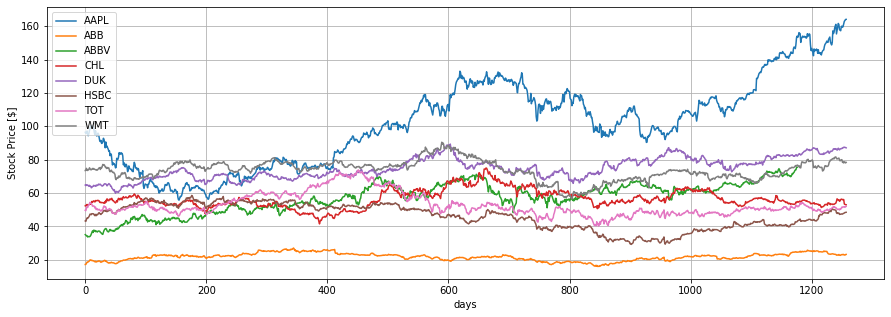

In [6]:
plt.figure(figsize=(15,5))
for i, name in enumerate(stocks_name):
    plt.plot(stocks_real[name], label=stocks_name[i])
plt.xlabel("days")
plt.ylabel("Stock Price [$]")
plt.legend()
plt.grid()

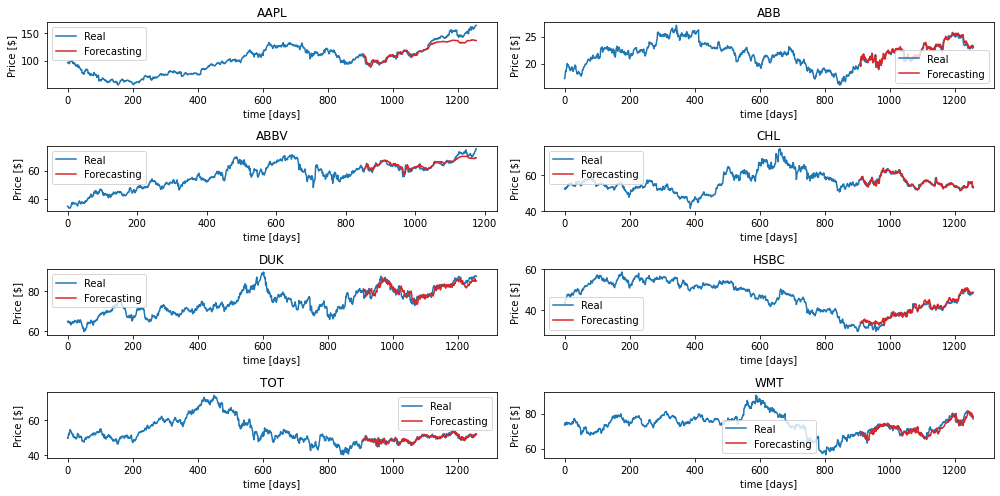

In [7]:
fig, ax = plt.subplots(4,2, figsize = (14,7))
for i in range(4):
    for j in range(2):
        l = len(stocks_real[stocks_name[j + 2*i]])
        l2 = len(stocks_forecasting[stocks_name[j + 2*i]])
        t2 = np.arange(l-l2,l)
        ax[i,j].plot(stocks_real[stocks_name[j + 2*i]])
        ax[i,j].plot(t2,stocks_forecasting[stocks_name[j + 2*i]], color="tab:red")
        ax[i,j].set_title(stocks_name[j + 2*i])
        ax[i,j].legend(["Real", "Forecasting"])
        ax[i,j].set_xlabel("time [days]")
        ax[i,j].set_ylabel("Price [$]")
plt.tight_layout()
plt.savefig("./Images/Stock_predictions.png")

# 3. Optimization Model - XS

The XS model consists of 

- 3 assets "AAPL", "ABB", and "ABBV".
- 2 periods of time of 30 days. 
- Holding period of 30 days. 
- Maximum inversion per asset of 50% of the total budget.

In [94]:
xs = {}

In [95]:
# Set parameters for assets and risk factor
xs["num_assets"] = 3 # set number of assets
xs["gamma"] = 0.5   # risk aversion to 0.5
xs["lambda"] = 0.001 # Transaction Cost
xs["holding_period"] = 30 # Days of keeping the assets
xs["periods"] = 2
xs["max_investment"] = np.array([0.5, 0.5, 0.5]) # Maximum investment per asset of the total budget
xs["assets"] = ["AAPL", "ABB", "ABBV"]
xs["rho"] = 5 # Lagrange multiplier for the budget constraint 

xs["data"] = [stocks_forecasting[name] for name in xs["assets"]]

xs["mu"] = mu_fun(xs["data"], xs["holding_period"])[-xs["periods"]:]
xs["sigma"] = cov_matrix(xs["data"], xs["holding_period"])
xs["qp"] = portfolioOptimization(xs["mu"], xs["sigma"][-xs["periods"]:], xs["gamma"],
                           xs["max_investment"], xs["lambda"], xs["rho"], simplified=True)
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
xs["qubo"] = QuadraticProgramToQubo().convert(xs["qp"])

In [97]:
xs["qubo"]

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolioOptimization

Minimize
 obj: - 0.008059504023 w0_0 - 0.022606130409 w0_1 - 0.015415473599 w0_2
      + 0.014582476783 w1_0 - 0.023514934815 w1_1 - 0.005708784120 w1_2 + [
      0.000000460358 w0_0^2 + 0.000001413460 w0_0*w0_1
      - 0.000000125588 w0_0*w0_2 + 0.000012672888 w0_1^2
      - 0.000000825215 w0_1*w0_2 + 0.000000941499 w0_2^2 + 0.000000979898 w1_0^2
      + 0.000001488766 w1_0*w1_1 + 0.000000073718 w1_0*w1_2
      + 0.000006637125 w1_1^2 + 0.000000369319 w1_1*w1_2 + 0.000000491954 w1_2^2
      ]/2
Subject To

Bounds
 0 <= w0_0 <= 1
 0 <= w0_1 <= 1
 0 <= w0_2 <= 1
 0 <= w1_0 <= 1
 0 <= w1_1 <= 1
 0 <= w1_2 <= 1

Binaries
 w0_0 w0_1 w0_2 w1_0 w1_1 w1_2
End

## 3.1 QAOA Solution using SPSA and COBYLA

In [98]:
xs["QAOA"] = {}

In [99]:
xs["QAOA"]["SPSA"] = Optimization_QAOA(xs["qubo"], reps=1, optimizer=SPSA(maxiter=50), local=True)

In [100]:
xs["QAOA"]["COBYLA"] = Optimization_QAOA(xs["qubo"], reps=1, optimizer=COBYLA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below execute the problem on real hardware.
</div>

In [ ]:
xs["QAOA"]["Real-COBYLA"] = Optimization_QAOA(xs["qubo"], reps=1, optimizer=COBYLA(maxiter=1),
                                                        provider=provider, backend=provider.get_backend("ibmq_qasm_simulator"))

## 3.2 VQE Solution using SPSA and SLSQP 

In [102]:
xs["VQE"] = {}

In [103]:
xs["ansatz"] = TwoLocal(xs["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [104]:
xs["VQE"]["COBYLA"] = Optimization_VQE(xs["qubo"], ansatz=xs["ansatz"], optimizer=COBYLA(maxiter=50), local=True)

In [105]:
xs["VQE"]["SPSA"] = Optimization_VQE(xs["qubo"], ansatz=xs["ansatz"], optimizer=SPSA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below execute the problem on real hardware.
</div>

In [ ]:
xs["VQE"]["Real-COBYLA"] = Optimization_VQE(xs["qubo"], ansatz=xs["ansatz"], optimizer=COBYLA(maxiter=5),
                                             provider=provider_7, backend=backend_7)

## 3.3 Solution using CPLEX

In [19]:
xs["CPLEX"]= CplexOptimizer().solve(xs["qubo"])

## 3.4 Summary of model XS

In [20]:
np.save(f"./Data/{user}/xs.npy", xs)

#xs = np.load(f"./Data/{user}/xs.npy", allow_pickle=True).item()

In [21]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
xs_sol = [xs[met][sol][0].x.reshape(xs["periods"],-1) for met in method for sol in solver] + [xs["CPLEX"].x.reshape(xs["periods"],-1)]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[xs[met][sol][0].fval for met in method for sol in solver] + [xs["CPLEX"].fval],              
              "Solution":xs_sol,
              "Profit [%]":[np.round(100*profits(_, xs["mu"], xs["lambda"], xs["periods"], xs["max_investment"]), 1) for _ in xs_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, xs["lambda"], xs["periods"], xs["max_investment"]) for _ in xs_sol]
             })

,Method,Solver,Cost fun,Solution,Profit [%],Transaction Cost [%]
0,QAOA,SPSA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
1,QAOA,COBYLA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
2,VQE,COBYLA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
3,VQE,SPSA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
4,CPLEX,,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"


# 4. Optimization Model - S

The model S consists of 

- 5 assets "AAPL", "ABB", "ABBV", "CHL", and "DUK".
- 3 periods of time of 30 days. 
- Holding period of 30 days. 
- Maximum inversion per asset of 25% of the total budget.

In [32]:
s = {}

In [34]:
# Set parameters for assets and risk factor
s["num_assets"] = 5 # set number of assets
s["gamma"] = 0.5   # risk aversion to 0.5
s["lambda"] = 0.001 # Transaction Cost
s["holding_period"] = 30 # Days of keeping the assets
s["periods"] = 3
s["max_investment"] = np.array([0.25, 0.25, 0.25, 0.25, 0.25]) # Maximum investment per asset of the total budget
s["assets"] = ["AAPL", "ABB", "ABBV","WMT", "DUK"]
s["rho"] = 5 # Lagrange multiplier for the budget constraint 

s["data"] = [stocks_forecasting[name] for name in s["assets"]]

s["mu"] = mu_fun(s["data"], s["holding_period"])[-s["periods"]:]
s["sigma"] = cov_matrix(s["data"], s["holding_period"])
s["qp"] = portfolioOptimization(s["mu"], s["sigma"][-s["periods"]:], s["gamma"],
                           s["max_investment"], s["lambda"], s["rho"])
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
s["qubo"] = QuadraticProgramToQubo().convert(s["qp"])

## 4.1 QAOA Solution using SPSA and COBYLA

In [35]:
s["QAOA"] = {}

In [36]:
s["QAOA"]["SPSA"] = Optimization_QAOA(s["qubo"], reps=1, optimizer=SPSA(maxiter=50), local=True)

In [37]:
s["QAOA"]["COBYLA"] = Optimization_QAOA(s["qubo"], reps=1, optimizer=COBYLA(maxiter=50), local=True)

In [104]:
s["QAOA"]["COBYLA-2"] = Optimization_QAOA(s["qubo"], reps=2, optimizer=COBYLA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below executes the problem on real hardware only available for Alberto
</div> 

In [ ]:
s["QAOA"]["Real-COBYLA"] = Optimization_QAOA(s["qubo"], reps=1, optimizer=COBYLA(maxiter=50), backend=backend_16,
                                            provider=provider_16)

## 4.2 VQE Solution using SPSA and COBYLA

In [38]:
s["VQE"] = {}
s["ansatz"] = TwoLocal(s["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [39]:
s["VQE"]["COBYLA"] = Optimization_VQE(s["qubo"], ansatz=s["ansatz"], optimizer=COBYLA(maxiter=50), local=True)

In [76]:
s["VQE"]["SPSA"] = Optimization_VQE(s["qubo"], ansatz=s["ansatz"], optimizer=SPSA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below executes the problem on real hardware only available for Alberto
</div> 

In [ ]:
s["Real-VQE"]["SPSA"] = Optimization_VQE(s["qubo"], ansatz=s["ansatz"], optimizer=COBYLA(maxiter=50), backend=backend_16,
                                            provider=provider_16)

## 4.3 Solution using CPLEX

In [41]:
s["CPLEX"]= CplexOptimizer().solve(s["qubo"])

## 4.4 Summary of model S


In [58]:
np.save(f"./Data/{user}/s.npy", s)

#s = np.load(f"./Data/{user}/s.npy", allow_pickle=True).item()

In [79]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
s_sol = [(s[met][sol][0].x + 0.001).reshape(s["periods"],-1).astype(int) for met in method for sol in solver] + [(s["CPLEX"].x+0.01).reshape(s["periods"],-1).astype(int)]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[s[met][sol][0].fval for met in method for sol in solver] + [s["CPLEX"].fval],              
              "Solution":s_sol,
              "Profit [%]":[np.round(100*profits(_, s["mu"], s["lambda"], s["periods"], s["max_investment"]), 1) for _ in s_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, s["lambda"], s["periods"], s["max_investment"]) for _ in s_sol]
             })

,Method,Solver,Cost fun,Solution,Profit [%],Transaction Cost [%]
0,QAOA,SPSA,-0.095315,"[[1, 1, 0, 1, 1], [1, 1, 1, 1, 0], [0, 1, 1, 1...","[2.9, 4.8, 1.7]","[0.1, 0.05, 0.05]"
1,QAOA,COBYLA,0.221688,"[[1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [0, 1, 1, 0...","[2.7, 4.6, 1.7]","[0.1, 0.05, 0.025]"
2,VQE,COBYLA,-0.091058,"[[1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [0, 1, 1, 1...","[2.7, 4.6, 1.8]","[0.1, 0.05, 0.0]"
3,VQE,SPSA,-0.083458,"[[1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 0...","[2.7, 4.6, 1.0]","[0.1, 0.05, 0.05]"
4,CPLEX,,-0.095315,"[[1, 1, 0, 1, 1], [1, 1, 1, 1, 0], [0, 1, 1, 1...","[2.9, 4.8, 1.7]","[0.1, 0.05, 0.05]"


# 5. Optimization Model - M

The model M consists of 

- 8 assets "AAPL", "ABB", "ABBV", "CHL", "DUK", "HSBC", "TOT", and "WMT".
- 4 periods of time of 30 days. 
- Holding period of 30 days. 
- Maximum inversion per asset of 20% of the total budget.

In [4]:
m = {}

In [6]:
# Set parameters for assets and risk factor
m["num_assets"] = 8 # set number of assets
m["gamma"] = 0.5   # risk aversion to 0.5
m["lambda"] = 0.001 # Transaction Cost
m["holding_period"] = 30 # Days of keeping the assets
m["periods"] = 4
m["max_investment"] = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]) # Maximum investment per asset of the total budget
m["assets"] = ["AAPL","ABB", "ABBV","CHL", "DUK", "HSBC", "TOT", "WMT"]
m["rho"] = 5 # Lagrange multiplier for the budget constraint 

m["data"] = [stocks_forecasting[name] for name in m["assets"]]

m["mu"] = mu_fun(m["data"], m["holding_period"])[-m["periods"]:]
m["sigma"] = cov_matrix(m["data"], m["holding_period"])
m["qp"] = portfolioOptimization(m["mu"], m["sigma"][-m["periods"]:], m["gamma"],
                           m["max_investment"], m["lambda"], m["rho"])
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
m["qubo"] = QuadraticProgramToQubo().convert(m["qp"])

<div class="alert alert-block alert-success">
In this case, the optimization requires 32 qubits. Therefore, it is needed to run the optimization portfolio in the qasm_simulator.
    
</div>

In [37]:
backend_sim = provider_7.get_backend("ibmq_qasm_simulator")

## 5.1 QAOA Solution using SPSA and COBYLA

In [38]:
m["QAOA"] = {}

In [ ]:
m["QAOA"]["SPSA"] = Optimization_QAOA(m["qubo"], reps=1, optimizer=SPSA(maxiter=50), backend=backend_sim,
                                      provider=provider_7)

In [ ]:
m["QAOA"]["COBYLA"] = Optimization_QAOA(m["qubo"], reps=1, optimizer=COBYLA(maxiter=50), backend=backend_sim,
                                      provider=provider_7)

## 5.2 VQE Solution using SPSA and COBYLA

In [ ]:
m["VQE"] = {}
m["ansatz"] = TwoLocal(m["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [ ]:
m["VQE"]["COBYLA"] = Optimization_VQE(m["qubo"], ansatz=m["ansatz"], optimizer=COBYLA(maxiter=50), backend=backend_sim,
                                     provider=provider_7)

In [ ]:
m["VQE"]["SPSA"] = Optimization_VQE(m["qubo"], ansatz=m["ansatz"], optimizer=SPSA(maxiter=50), backend=backend_sim,
                                   provider=provider_7)

## 5.3 Solution using CPLEX

In [ ]:
m["CPLEX"]= CplexOptimizer().solve(m["qubo"])

## 5.4 Summary of model M

In [ ]:
np.save(f"./Data/{user}/m.npy", m)

#m = np.load(f"./Data/{user}/s.npy", allow_pickle=True).item()

In [ ]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
m_sol = [m[met][sol][0].x.reshape(m["periods"],-1).astype(int) for met in method for sol in solver] + [(m["CPLEX"].x+0.01).reshape(m["periods"],-1).astype(int)]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[m[met][sol][0].fval for met in method for sol in solver] + [m["CPLEX"].fval],              
              "Solution":m_sol,
              "Profit [%]":[np.round(100*profits(_, m["mu"], m["lambda"], m["periods"], m["max_investment"]), 1) for _ in m_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, m["lambda"], m["periods"], m["max_investment"]) for _ in m_sol]
             })

# 6. Original Contributions

Here, we present two further considerations that could make the model more robust:

- The first is to make the budget constraint a weak constraint that can be partially avoided if the returns of a period of time are enoughly good and the uncertainty of the forecasting is considerably low.


- The second consideration is to include the risk associated with the Quantum Machine Learning forecasting as a term in the cost function.

<center><img src="images/New-Cost-function.png" width="800"></center>

For this case, we will only use the optimization Model S.


## 6.1 Optimization Model - S New Cost Function

In [7]:
s_new = {}

In [47]:
# Set parameters for assets and risk factor
s_new["num_assets"] = 5 # set number of assets
s_new["gamma"] = 0.5   # risk aversion to 0.5
s_new["lambda"] = 0.001 # Transaction Cost
s_new["holding_period"] = 30 # Days of keeping the assets
s_new["periods"] = 3
s_new["max_investment"] = np.array([0.25, 0.25, 0.25, 0.25, 0.25]) # Maximum investment per asset of the total budget
s_new["assets"] = ["AAPL", "ABB", "ABBV","WMT", "DUK"]
s_new["kappa"] = np.array([kappa[name] for name in s_new["assets"]])
s_new["rho"] = 0.02 # Lagrange multiplier for the budget constraint 
s_new["beta"] = 0.1

s_new["data"] = [stocks_forecasting[name] for name in s_new["assets"]]

s_new["mu"] = mu_fun(s_new["data"], s_new["holding_period"])[-s_new["periods"]:]
s_new["U"] = mu_fun(s_new["data"], s_new["holding_period"])[:-s_new["periods"]].mean(axis=0)

s_new["sigma"] = cov_matrix(s_new["data"], s_new["holding_period"])
s_new["qp"] = portfolioOptimization_NewApproach(s_new["mu"], s_new["sigma"][-s_new["periods"]:], s_new["gamma"],
                           s_new["kappa"],s_new["max_investment"], s_new["U"], Lambda=s_new["lambda"], rho=s_new["rho"],
                                                beta=s_new["beta"])
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
s_new["qubo"] = QuadraticProgramToQubo().convert(s_new["qp"])

## 7.1 QAOA Solution using SPSA and COBYLA

In [13]:
s_new["QAOA"] = {}

In [64]:
s_new["QAOA"]["SPSA"] = Optimization_QAOA(s_new["qubo"], reps=1, optimizer=SPSA(maxiter=50), local=True)

In [50]:
s_new["QAOA"]["COBYLA"] = Optimization_QAOA(s_new["qubo"], reps=1, optimizer=COBYLA(maxiter=50), local=True)

In [103]:
s_new["QAOA"]["COBYLA-2"] = Optimization_QAOA(s_new["qubo"], reps=2, optimizer=COBYLA(maxiter=50), local=True)

## 7.2 VQE Solution using SPSA and COBYLA


In [51]:
s_new["VQE"] = {}
s_new["ansatz"] = TwoLocal(s_new["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [52]:
s_new["VQE"]["COBYLA"] = Optimization_VQE(s_new["qubo"], ansatz=s_new["ansatz"], optimizer=COBYLA(maxiter=50), local=True)

In [53]:
s_new["VQE"]["SPSA"] = Optimization_VQE(s_new["qubo"], ansatz=s_new["ansatz"], optimizer=SPSA(maxiter=50), local=True)

## 7.3 Solution using CPLEX

In [54]:
s_new["CPLEX"]= CplexOptimizer().solve(s_new["qubo"])

## 7.4 Summary of model S - New approach

In [60]:
np.save(f"./Data/{user}/s_new.npy", s_new)

#s = np.load(f"./Data/{user}/s_new.npy", allow_pickle=True).item()

In [61]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
s_sol = [(s_new[met][sol][0].x + 0.001).reshape(s_new["periods"],-1).astype(int) for met in method for sol in solver] + [(s_new["CPLEX"].x+0.01).reshape(s_new["periods"],-1).astype(int)]
s_new["profit"] = [np.round(100*profits(_, s_new["mu"], s_new["lambda"], s_new["periods"], s_new["max_investment"]), 1) for _ in s_sol]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[s_new[met][sol][0].fval for met in method for sol in solver] + [s_new["CPLEX"].fval],              
              "Solution":s_sol,
              "Profit [%]":[np.round(100*profits(_, s_new["mu"], s_new["lambda"], s_new["periods"], s_new["max_investment"]), 1) for _ in s_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, s_new["lambda"], s_new["periods"], s_new["max_investment"]) for _ in s_sol]
             })

,Method,Solver,Cost fun,Solution,Profit [%],Transaction Cost [%]
0,QAOA,SPSA,-0.087121,"[[1, 0, 1, 1, 1], [1, 1, 1, 1, 0], [0, 1, 1, 1...","[2.7, 4.8, 1.7]","[0.1, 0.05, 0.05]"
1,QAOA,COBYLA,-0.085171,"[[1, 1, 0, 1, 1], [1, 1, 1, 1, 1], [0, 1, 0, 1...","[2.9, 5.0, 1.4]","[0.1, 0.025, 0.05]"
2,VQE,COBYLA,-0.088973,"[[1, 1, 1, 1, 1], [0, 1, 1, 1, 1], [0, 1, 1, 1...","[3.2, 4.6, 1.8]","[0.125, 0.025, 0.0]"
3,VQE,SPSA,-0.091716,"[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1...","[3.2, 5.1, 1.7]","[0.125, 0.0, 0.025]"
4,CPLEX,,-0.091716,"[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1...","[3.2, 5.1, 1.7]","[0.125, 0.0, 0.025]"


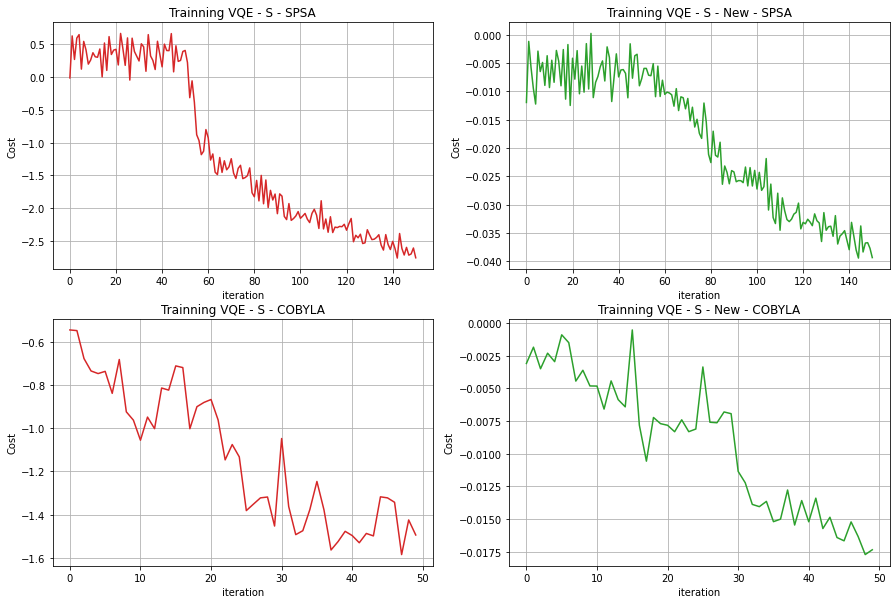

In [101]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(s["VQE"]["SPSA"][1]["mean"], label="S", color="tab:red")
ax[0,1].plot(s_new["VQE"]["SPSA"][1]["mean"], label="S-New", color="tab:green")
ax[1,0].plot(s["VQE"]["COBYLA"][1]["mean"], label="S", color="tab:red")
ax[1,1].plot(s_new["VQE"]["COBYLA"][1]["mean"], label="S-New", color="tab:green")
ax[0,0].set_title("Trainning VQE - S - SPSA")
ax[0,1].set_title("Trainning VQE - S - New - SPSA")
ax[1,0].set_title("Trainning VQE - S - COBYLA")
ax[1,1].set_title("Trainning VQE - S - New - COBYLA")
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("iteration")
        ax[i,j].set_ylabel("Cost")
        ax[i,j].grid()
plt.savefig("./Images/VQE-S-Training.png")

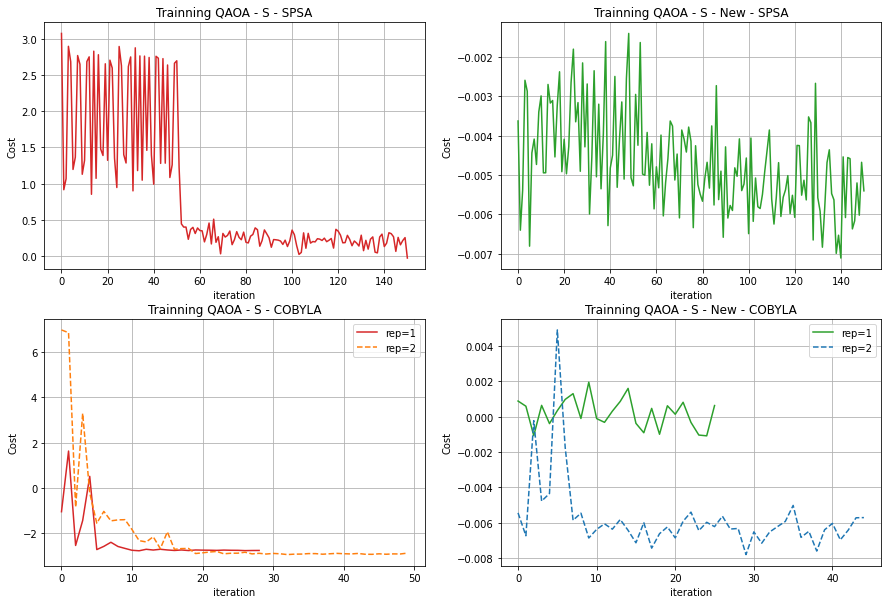

In [113]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(s["QAOA"]["SPSA"][1]["mean"], label="S", color="tab:red")
ax[0,1].plot(s_new["QAOA"]["SPSA"][1]["mean"], label="S-New", color="tab:green")
ax[1,0].plot(s["QAOA"]["COBYLA"][1]["mean"], label="rep=1", color="tab:red")
ax[1,0].plot(s["QAOA"]["COBYLA-2"][1]["mean"], label="rep=2", color="tab:orange", linestyle="--")
ax[1,0].legend()
ax[1,1].plot(s_new["QAOA"]["COBYLA"][1]["mean"], label="rep=1", color="tab:green")
ax[1,1].plot(s_new["QAOA"]["COBYLA-2"][1]["mean"], label="rep=2", color="tab:blue", linestyle="--")
ax[1,1].legend()
ax[0,0].set_title("Trainning QAOA - S - SPSA")
ax[0,1].set_title("Trainning QAOA - S - New - SPSA")
ax[1,0].set_title("Trainning QAOA - S - COBYLA")
ax[1,1].set_title("Trainning QAOA - S - New - COBYLA")
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("iteration")
        ax[i,j].set_ylabel("Cost")
        ax[i,j].grid()
plt.savefig("./Images/QAOA-S-Training.png")

# 7. References
[1] Mugel, S., Kuchkovsky, C., Sánchez, E., Fernández-Lorenzo, S., Luis-Hita, J., Lizaso, E., & Orús, R. (2022). Dynamic portfolio optimization with real datasets using quantum processors and quantum-inspired tensor networks. Physical Review Research, 4(1), 1–13. https://doi.org/10.1103/PhysRevResearch.4.013006

[2] Xu, Y., & Cohen, S. B. (2018). Stock Movement Prediction from Tweets and Historical Prices. 1970–1979.